### Setup

In [36]:
# Main
import numpy as np
import pandas as pd

# Modeling
import statsmodels.api as sm

# Unit root
from arch.unitroot import ADF, DFGLS, PhillipsPerron, KPSS, ZivotAndrews
from quantileADF import QAR, comparisonPlot

# Tests and function
from statsmodels.stats.stattools import jarque_bera

# Plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Setting up Urls
repoUrl = 'https://raw.githubusercontent.com/vlad-yeghiazaryan/QADF/master/data/'
broadREERsUrl = repoUrl + 'broadREERs.csv'
narrowREERsUrl = repoUrl + 'narrowREERs.csv'

In [37]:
def univariate(data):
    univariateTests = pd.DataFrame()
    univariateTests['ADF'] = data.apply(lambda col: ADF(col).pvalue)
    univariateTests['DFGLS'] = data.apply(lambda col: DFGLS(col).pvalue)
    univariateTests['PP'] = data.apply(lambda col: PhillipsPerron(col).pvalue)
    univariateTests['KPSS'] = data.apply(lambda col: KPSS(col).pvalue)
    univariateTests['ZA'] = data.apply(lambda col: ZivotAndrews(col).pvalue)
    return univariateTests.applymap(lambda x: '%.0f' % x if x.is_integer() else '%.3f' % x)

In [38]:
def comparisonPlots(data,fileName='changesOverQuantiles'):
    figs = []
    for index, pos in enumerate(range(0, data.shape[1], 3)):
        columns = data.columns[pos: min(data.shape[1], pos+3)]
        figsize = (len(columns)*5, 6)
        countries = data[columns]
        fig = comparisonPlot(countries, figsize=figsize)
        figs.append(fig)
        plt.savefig(f'Outputs/{fileName}-{index+1}', dpi = 300)
    return figs

In [39]:
def markovRegimeSwitchingPlots(data, fileName='regimeSwitchingProbabilities'):
    figs = []
    for i, pos in enumerate(range(0, data.shape[1], 2)):
        columns = data.columns[pos: min(data.shape[1], pos+2)]
        figsize = (len(columns)*5, 6)
        fig = plt.figure()
        for index, country in enumerate(columns):
            mainModel = QAR(data[country])
            ax = fig.add_subplot(1, len(columns), index+1)
            mod = sm.tsa.MarkovRegression(mainModel.y, trend='c', k_regimes=2, order=2, freq='MS').fit()
            title = 'Probability of being in the high regime'
            ax = mod.smoothed_marginal_probabilities[1].plot(title=title, figsize=(12,3))
            ax.legend(labels=[mainModel.name])
            ax.axvline('2015-1-1', color='black')
            trans = ax.get_xaxis_transform()
            plt.text('2015-1-1', -.1, 'EAEU', transform=trans, weight='bold')
            ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        figs.append(fig)
        plt.savefig(f'Outputs/{fileName}-{i+1}', dpi = 300)
    return figs

### REERs of EAEU countries

In [40]:
broadREERs = pd.read_csv(broadREERsUrl, index_col=0, parse_dates=True)
narrowREERs = pd.read_csv(narrowREERsUrl, index_col=0, parse_dates=True)

# Extracting country information
countries = ['Armenia', 'Belarus', 'Kazakhstan', 'Kyrgyz Republic',
             'Moldova', 'Russian Federation', 'Tajikistan', 'Ukraine']

startDate = '2000-01-01'
startDateWithoutTaj = '1995-01-01'

data = broadREERs[countries].loc[startDate:]
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2000-01-01 to 2020-11-01
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Armenia             251 non-null    float64
 1   Belarus             251 non-null    float64
 2   Kazakhstan          251 non-null    float64
 3   Kyrgyz Republic     251 non-null    float64
 4   Moldova             251 non-null    float64
 5   Russian Federation  251 non-null    float64
 6   Tajikistan          251 non-null    float64
 7   Ukraine             251 non-null    float64
dtypes: float64(8)
memory usage: 17.6 KB


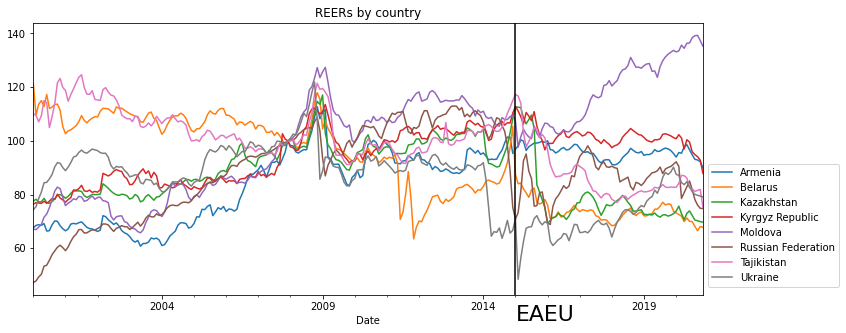

In [41]:
data.plot(kind='line', subplots=False, sharey=True, 
          layout=(1,1), figsize=(12, 5), title='REERs by country')

plt.text('2015-1-1', 33, 'EAEU', fontdict={'size': 22})
plt.axvline('2015-1-1', color='black')
plt.legend(loc='best', bbox_to_anchor=(1.0, 0.5), prop={'size': 10})
plt.savefig('Outputs/REERsByCountry', dpi = 300)
plt.show()

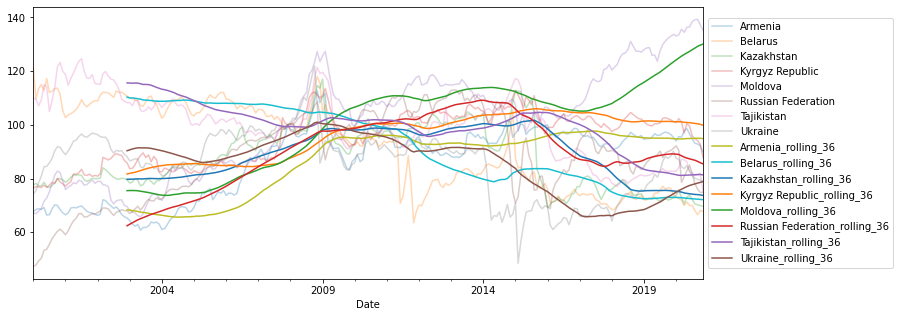

In [42]:
window = 36
rolling = data.rolling(window).mean()
rolling.columns = [i + '_rolling_' + str(window) for i in data.columns]
ax = data.plot(alpha = .3)
rolling.plot(ax = ax, figsize=(12, 5))

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [43]:
colNames = {
    'count': 'N',
    'mean': 'Mean',
    'std': 'St.dev.',
    'min': 'Min.', 
    'max': 'Max.',
    '50%': 'Median', 
}
tests = ['Jarque-Bera', 'Jarque-Bera (P-value)', 'Skewness', 'Kurtosis']
include = ['N', 'Mean', 'Median', 'Min.', 'Max.', 'St.dev.', 
           'Skewness', 'Kurtosis', 'Jarque-Bera', 'Jarque-Bera (P-value)']

# Summary Setup
summaryStatistics = data.describe().T
JB = data.apply(jarque_bera).T
summaryStatistics[tests] = JB
summaryStatistics.rename(columns=colNames, inplace=True)
summaryStatistics[include].applymap(lambda x: '%.0f' % x if x.is_integer() else '%.3f' % x)

,N,Mean,Median,Min.,Max.,St.dev.,Skewness,Kurtosis,Jarque-Bera,Jarque-Bera (P-value)
Armenia,251,86.436,91.964,60.748,112.670,12.978,-0.587,1.967,25.576,0.000
Belarus,251,92.156,93.926,63.490,121.250,15.739,-0.112,1.465,25.185,0.000
Kazakhstan,251,87.638,85.562,69.135,117.063,11.577,0.288,1.980,14.334,0.001
Kyrgyz Republic,251,95.324,98.990,76.395,113.535,9.665,-0.282,1.842,17.350,0.000
Moldova,251,101.414,105.679,65.751,139.276,19.526,-0.105,1.949,12.008,0.002
Russian Federation,251,87.958,89.740,47.244,112.963,15.747,-0.349,2.303,10.171,0.006
Tajikistan,251,99.532,100.077,75.248,124.610,11.582,-0.078,2.382,4.249,0.119
Ukraine,251,85.497,88.550,48.422,121.900,11.897,-0.365,2.993,5.561,0.062


In [44]:
univariate(data)

,ADF,DFGLS,PP,KPSS,ZA
Armenia,0.394,0.417,0.463,0.000,0.052
Belarus,0.769,0.857,0.562,0.000,0.124
Kazakhstan,0.241,0.074,0.545,0.039,0.000
Kyrgyz Republic,0.230,0.357,0.242,0.000,0.498
Moldova,0.713,0.882,0.733,0.000,0.548
Russian Federation,0.130,0.532,0.116,0.004,0.345
Tajikistan,0.415,0.287,0.706,0.000,0.156
Ukraine,0.301,0.124,0.205,0.002,0.211


/Users/victor_yerz/anaconda3/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/Users/victor_yerz/anaconda3/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/Users/victor_yerz/anaconda3/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/Users/victor_yerz/anaconda3/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/Users/victor_yerz/anaconda3

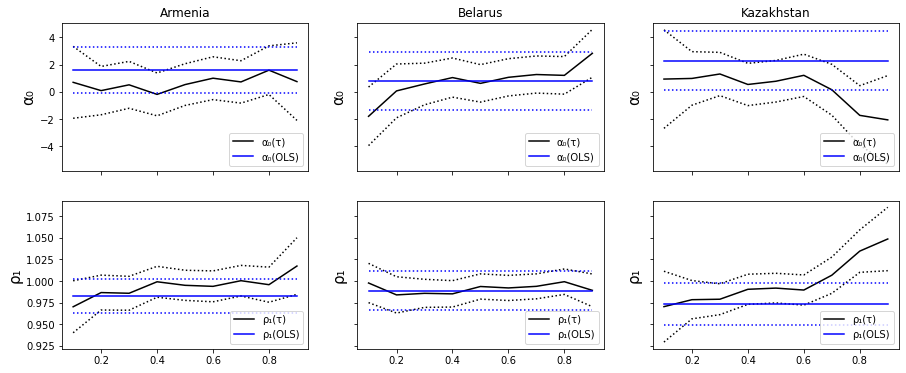

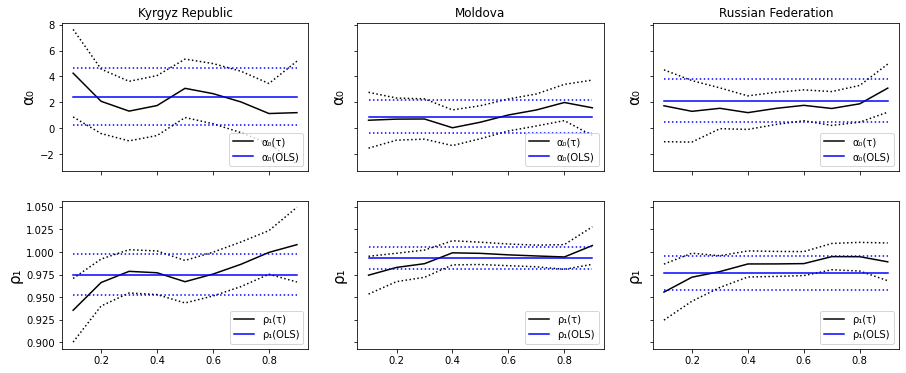

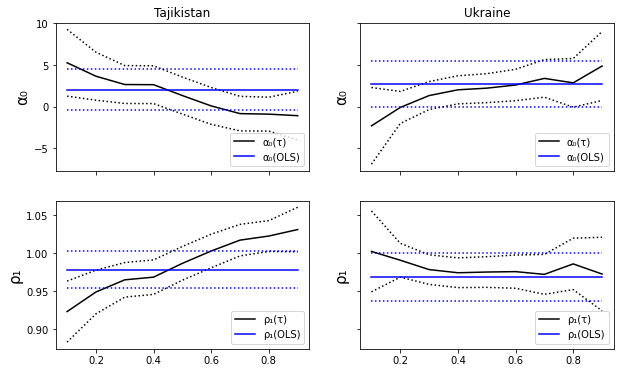

In [45]:
comparisonPlots(data)
plt.show()

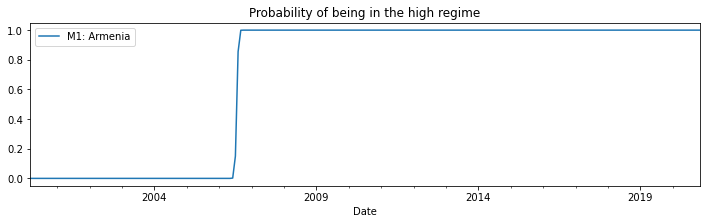

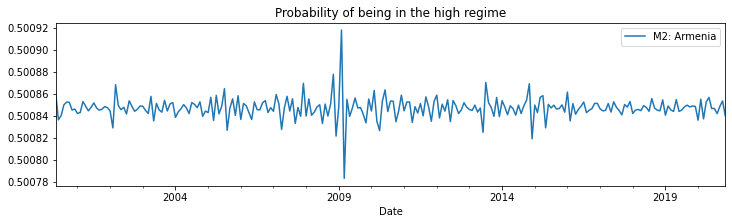

Model-1 exprected Durations Low vs High (future persistence in months): [190.87416977 286.09326068]
Model-2 exprected Durations Low vs High (future persistence in months): [2.24588581 2.25350824]


In [46]:
#### Markov Switching
# Fit the model
# (a switching mean is the default of the MarkovRegession model)
mainModel = QAR(data['Armenia'])

# Extracting endog and exog
y = mainModel.y
X = mainModel.X

mod1 = sm.tsa.MarkovRegression(y, trend='c', k_regimes=2, order=2, freq='MS', 
                               switching_variance=False)

mod2 = sm.tsa.MarkovAutoregression(y, trend='c', k_regimes=2, order=2, freq='MS', 
                                   switching_variance=False, switching_ar=False)

res1_REER = mod1.fit()
res2_REER = mod2.fit()

# Plotting
title = 'Probability of being in the high regime'
res1_REER.smoothed_marginal_probabilities[1].plot(title=title, figsize=(12,3))
plt.legend(labels=['M1: '+ mainModel.name])
plt.show()
res2_REER.smoothed_marginal_probabilities[1].plot(title=title, figsize=(12,3))
plt.legend(labels=['M2: '+ mainModel.name])
plt.show()
print("Model-1 exprected Durations Low vs High (future persistence in months):",res1_REER.expected_durations)
print("Model-2 exprected Durations Low vs High (future persistence in months):",res2_REER.expected_durations)

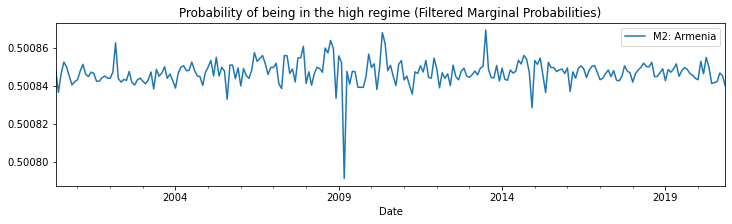

In [47]:
# Plotting
title = 'Probability of being in the high regime (Filtered Marginal Probabilities)'
res2_REER.filtered_marginal_probabilities[1].plot(title=title, figsize=(12,3))
plt.legend(labels=['M2: '+ mainModel.name])
plt.show()

/Users/victor_yerz/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


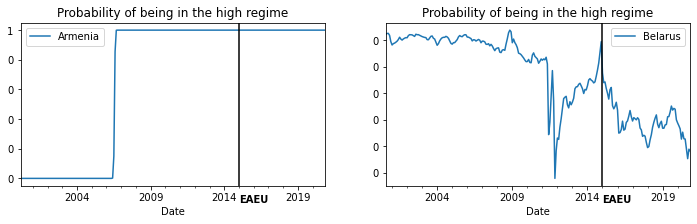

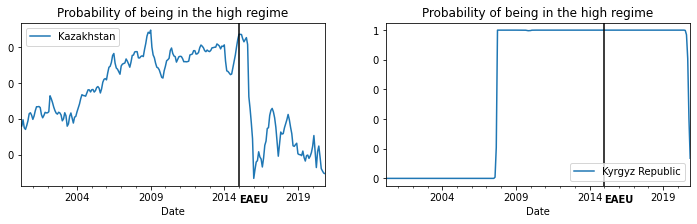

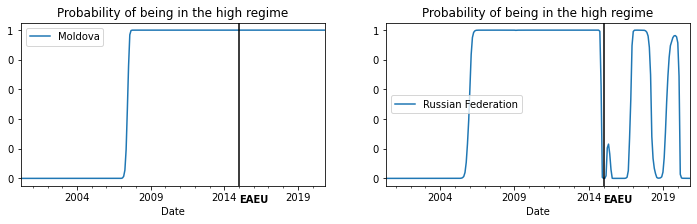

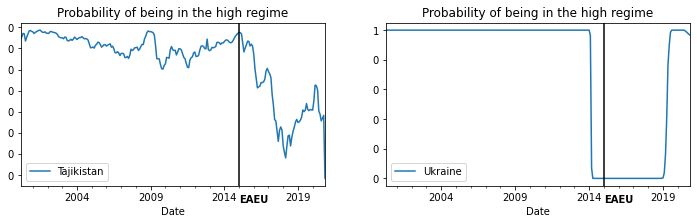

In [48]:
markovRegimeSwitchingPlots(data)
plt.show()